In [1]:
import numpy as np
import pandas as pd
!conda run -n tf_on_gpu python3 -m pip install "dask[diagnostics]"
import dask.dataframe as ddf
import uproot

  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.



In [2]:
from glob import glob
file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j100/*.root"
file_list = glob(file_pattern)
print (f"Found {len(file_list)} files from {file_pattern}")  

Found 10 files from /workarea/cloud-storage/anderlinil/LamarrBenderTrain/j100/*.root


In [3]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

from functools import partial
sim = (ddf.from_map (partial(read_root, tree="TrackingTupler/sim"), file_list)
          .query("acceptance <= 1")
       )
reco = ddf.from_map (partial(read_root, tree="TrackingTupler/reco"), file_list)


In [4]:
sim.columns

Index(['mc_key', 'evtNumber', 'runNumber', 'acceptance', 'reconstructible',
       'recobleCat', 'mcID', 'mcIDmother', 'mc_charge', 'fromSignal',
       'reconstructed', 'type', 'mc_vertexType', 'mc_primaryVertexType',
       'mc_motherVertexType', 'mc_x', 'mc_y', 'mc_z', 'mc_r', 'mc_tx', 'mc_ty',
       'mc_px', 'mc_py', 'mc_pz', 'mc_p', 'mc_pt', 'mc_eta', 'mc_phi',
       'mc_mass', 'x_ClosestToBeam', 'y_ClosestToBeam', 'z_ClosestToBeam',
       'tx_ClosestToBeam', 'ty_ClosestToBeam', 'px_ClosestToBeam',
       'py_ClosestToBeam', 'pz_ClosestToBeam', 'p_ClosestToBeam',
       'pt_ClosestToBeam', 'eta_ClosestToBeam', 'phi_ClosestToBeam',
       'mass_ClosestToBeam'],
      dtype='object')

In [5]:
sim['mc_log10_p'] = np.log(sim.mc_p)/np.log(10)
sim['mc_is_e'] = abs(sim.mcID).isin([11]).astype(np.float32)
sim['mc_is_mu'] = abs(sim.mcID).isin([13]).astype(np.float32)
sim['mc_is_h'] = abs(sim.mcID).isin([211, 321, 2212]).astype(np.float32)

In [6]:
acceptance_vars = ["mc_x", "mc_y", "mc_z", "mc_log10_p", "mc_px", "mc_py", "mc_is_e", "mc_is_mu", "mc_is_h", "mc_charge"]
acceptance_labels = ["acceptance"]

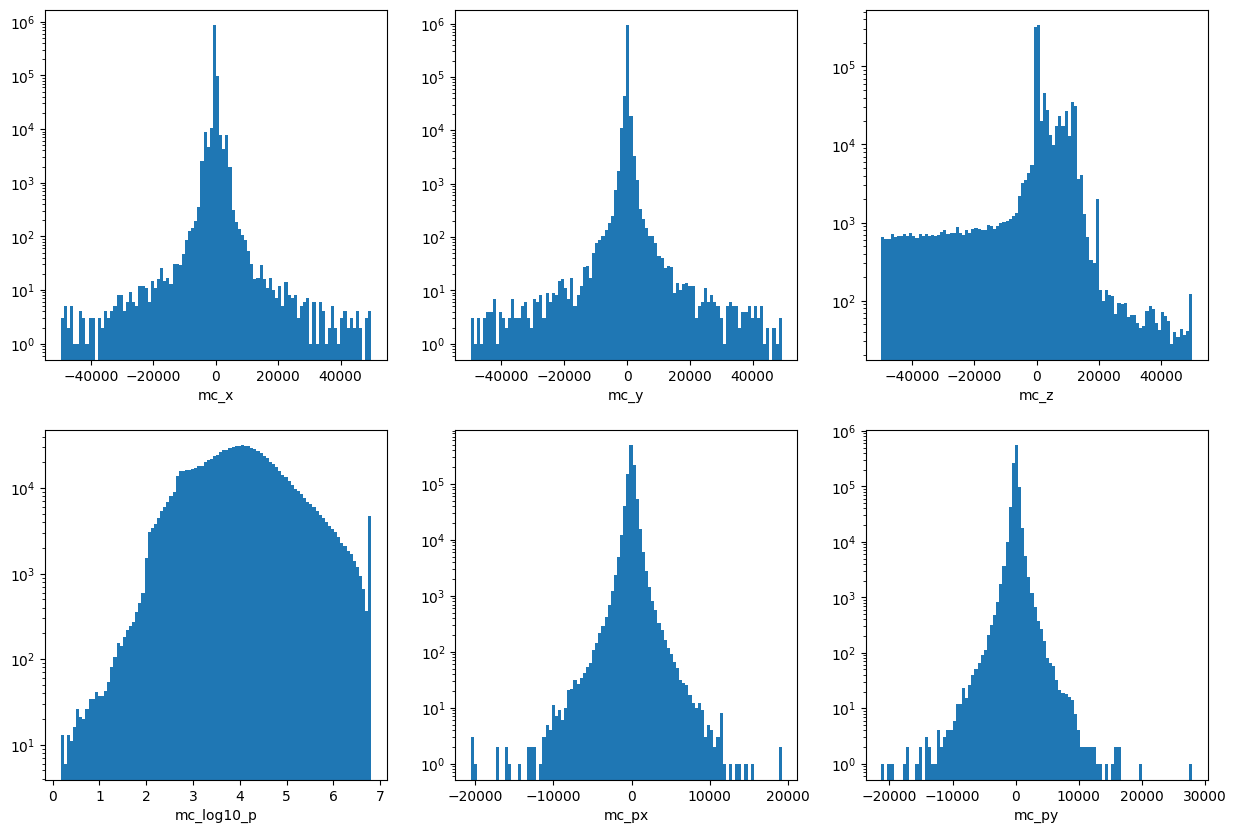

In [7]:
# Performs checks and plots on the first 100k rows
import matplotlib.pyplot as plt

df = sim[acceptance_vars].head(1_000_000, npartitions=10)
plt.figure(figsize=(15,10))
for iVar, var in enumerate(acceptance_vars[:6], 1):
    plt.subplot(2, 3, iVar)
    plt.hist(df[var], bins=100)
    plt.xlabel(var)
    plt.yscale('log')

plt.show()

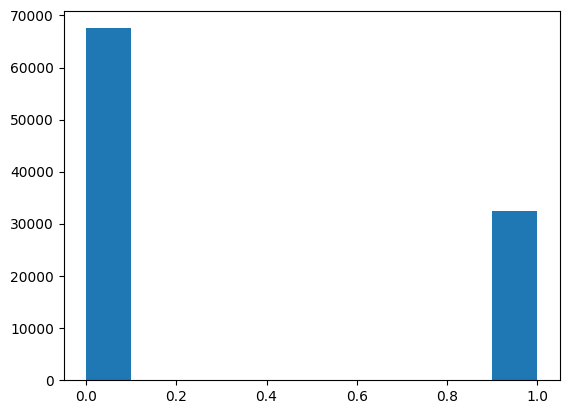

In [8]:
plt.hist(sim[acceptance_labels].head(100_000).values.flatten())
plt.show()

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

X = df.values

preprocessing_step = ColumnTransformer([
    ("quantile", QuantileTransformer(output_distribution='normal'), list(range(6))),
    ("flags", "passthrough", list(range(6,X.shape[1])))
])
preprocessing_step = preprocessing_step.fit(X)

In [10]:
def to_yX_array(dataframe):
    array = dataframe.values.astype(np.float32)
    array.compute_chunk_sizes()
    return array.rechunk((1_000_000, array.shape[1]))    

sim_train, sim_test, sim_validation = sim.random_split([0.5, 0.4, 0.1])
acc_yX_train = to_yX_array(sim_train[acceptance_labels + acceptance_vars])
acc_yX_test = to_yX_array(sim_test[acceptance_labels + acceptance_vars])
acc_yX_validation = to_yX_array(sim_validation[acceptance_labels + acceptance_vars])

acc_yX_train

dask.array<rechunk-merge, shape=(2645633, 11), dtype=float32, chunksize=(1000000, 11), chunktype=numpy.ndarray>

In [11]:
import os
import shutil
import tensorflow as tf
from tqdm.auto import tqdm
import dask.array

def save_as_tf_records(array: dask.array.Array, output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    for block in tqdm(array.blocks, desc=f"Saving to {output_dir}", total=np.prod(array.blocks.shape)):
        concrete_block = block.compute()
        y = concrete_block[:, 0:1].astype(np.float32)
        X = concrete_block[:, 1: ].astype(np.float32)
        prep_X = preprocessing_step.transform(X)
        dataset = tf.data.Dataset.from_tensor_slices((prep_X, y))

        tf.data.experimental.save(dataset, output_dir)

save_as_tf_records(acc_yX_train, "acceptance-train.tfrecords")
save_as_tf_records(acc_yX_test, "acceptance-test.tfrecords")
save_as_tf_records(acc_yX_validation, "acceptance-validation.tfrecords")

/usr/local/miniconda3/envs/tf_on_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving to acceptance-train.tfrecords:   0%|          | 0/3 [00:00<?, ?it/s]2022-12-07 13:59:59.645528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 13:59:59.658902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 13:59:59.660828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node 

In [12]:
import pickle
import os.path
output_file = "/workarea/cloud-storage/anderlinil/models/acceptance/tX.pkl"
output_dir = os.path.dirname(output_file)
!mkdir -p {output_dir}
with open(output_file, 'wb') as f:
    pickle.dump(preprocessing_step, f)